In [ ]:
# === Imports ===
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import t

# PDF/plot utils
from matplotlib.backends.backend_pdf import PdfPages
from PyPDF2 import PdfReader
from pdf2image import convert_from_path

# rpy2 and R packages
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr

# === Activate pandas <-> R conversion ===
pandas2ri.activate()

# === Import R packages ===
lme4 = importr('lme4')
lmerTest = importr('lmerTest')
car = importr('car')

# === Global paths and config ===
PROJECT_PATH = '/Users/labneuro2/Documents/lab/SBvsMB4'
EXCEL_PATH = os.path.join(PROJECT_PATH, "portrait_divergence_results.xlsx")
OUTPUT_DIR = os.path.join(PROJECT_PATH, "clean_report")
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
def fit_lmer_models(result, model_type, method_filter=None):
    # Define levels for the 'Trimmed' factor
    trimmed_levels = [str(i) for i in range(5, 14)]
    if method_filter:
        # Filter data for the specified method
        result = result[result['Method'] == method_filter].copy()
        robjects.globalenv['data_r'] = pandas2ri.py2rpy(result)
        robjects.r(f'''
                    data_r$Trimmed <- factor(data_r$Trimmed, levels = c({", ".join(f'"{x}"' for x in trimmed_levels)}))
                    contrasts(data_r$Trimmed) <- contr.sum(length(levels(data_r$Trimmed)))
                
                    model_test <- lmer({model_type}, data = data_r)
                
                    b <- fixef(model_test)
                    vcov_mat <- vcov(model_test)
                
                    model_summary_raw <- capture.output(summary(model_test))
                    model_anova <- capture.output(Anova(model_test, type=2, test.statistic="F"))
                    ''')
    else: 
        # Use all data, set contrasts for both 'Method' and 'Trimmed'
        robjects.globalenv['data_r'] = pandas2ri.py2rpy(result)
        robjects.r(f'''
                    data_r$Trimmed <- factor(data_r$Trimmed, levels = c({", ".join(f'"{x}"' for x in trimmed_levels)}))
                    data_r$Method <- factor(data_r$Method)
                    contrasts(data_r$Method) <- contr.treatment(levels(data_r$Method), base = which(levels(data_r$Method) == "SB"))
                    contrasts(data_r$Trimmed) <- contr.sum(length(levels(data_r$Trimmed)))
                
                    model_test <- lmer({model_type}, data = data_r)
                
                    b <- fixef(model_test)
                    vcov_mat <- vcov(model_test)
                
                    model_summary_raw <- capture.output(summary(model_test))
                    model_anova <- capture.output(Anova(model_test, type=2, test.statistic="F"))
                    ''')
    model = robjects.r('model_test')

    # Mapping for 'Trimmed' and 'Method' effect names
    trimmed_map = {f"Trimmed{i+1}": f"Trimmed: {level}" for i, level in enumerate(trimmed_levels[:-1])}
    method_map = {'MethodMB4': 'Method: MB4', 'MethodSB': 'Method: SB'}

    summary_lines = "\n".join(robjects.r('model_summary_raw')).splitlines()
    processed_lines = []

    for line in summary_lines:
        for orig, label in trimmed_map.items():
            if line.strip().startswith(orig):
                line = line.replace(orig, label)
        for orig, label in method_map.items():
            if line.strip().startswith(orig):
                line = line.replace(orig, label)

        processed_lines.append(line)

    # Get parameter estimates and effect names
    betas = np.array(robjects.r('as.numeric(fixef(model_test))'))
    names = list(robjects.r('names(fixef(model_test))'))
    vcov = np.array(robjects.r('as.matrix(vcov(model_test))'))
    dfs = np.array(robjects.r('as.numeric(summary(model_test)$coefficients[, "df"])'))

    # Build dictionary of effect estimates
    effect_estimates = {}
    for i, name in enumerate(names):
        beta = betas[i]
        se = np.sqrt(vcov[i, i])
        df = dfs[i]
        t_val = beta / se
        p_val = float(2 * (1 - t.cdf(np.abs(t_val), df)))
        t_crit = t.ppf(0.975, df)
        ci_low = round(beta - t_crit * se, 3)
        ci_high = round(beta + t_crit * se, 3)

        effect_estimates[name] = {
            'beta': round(beta, 3),
            'se': round(se, 3),
            'df': round(df, 1),
            't': round(t_val, 3),
            'p': round(p_val, 4),
            'ci': (ci_low, ci_high)
        }

    summary_text = "\n".join(processed_lines)
    anova_text = "\n".join(robjects.r('model_anova'))

    return model, summary_text, anova_text, effect_estimates

In [ ]:
# Quadratic model function
def quadratic_model(t, a, b, c):
    return a * t**2 + b * t + c

# Function to analyze trend for each method
def analyze_trend_per_method(result, method):
    # Filter data for the given method
    method_data = result[result['Method'] == method]
    
    # Calculate mean divergence
    mean_divergence = method_data.groupby('Trimmed')['Divergence'].mean()
    trimmed_levels = mean_divergence.index.astype(float)
    
    # Fit quadratic model
    params, cov = curve_fit(quadratic_model, trimmed_levels, mean_divergence)
    a, b, c = params
    errors = np.sqrt(np.diag(cov))

    # Calculate extremum point (minimum/maximum)
    t_ext = -b / (2 * a)
    y_ext = quadratic_model(t_ext, *params)

    # Calculate model fit
    y_pred = quadratic_model(trimmed_levels, *params)
    residuals = mean_divergence - y_pred
    ss_res = np.sum(residuals ** 2)  # Sum of Squared Errors (SSE)
    ss_tot = np.sum((mean_divergence - np.mean(mean_divergence)) ** 2)  # Total Sum of Squares (SST)
    r_squared = 1 - (ss_res / ss_tot)
    r_squared_adj = 1 - (1 - r_squared) * (len(trimmed_levels) - 1) / (len(trimmed_levels) - len(params) - 1)

    # F test (ANOVA)
    df_model = len(params) - 1  # Number of model parameters
    df_resid = len(trimmed_levels) - len(params)
    ms_model = (ss_tot - ss_res) / df_model
    ms_res = ss_res / df_resid
    f_value = ms_model / ms_res
    p_value_f = 1 - stats.f.cdf(f_value, df_model, df_resid)

    # t-test for model coefficients
    t_values = params / errors
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), df_resid)) for t in t_values]

    # Add vertex coordinates and equation
    vertex_x = t_ext
    vertex_y = y_ext
    equation = f"y = {a:.4f}t^2 + {b:.4f}t + {c:.4f}"

    # Save results to dictionary
    result_summary = {
        "Method": method,
        "a": a, "a_se": errors[0], "a_t": t_values[0], "a_p": p_values[0],
        "b": b, "b_se": errors[1], "b_t": t_values[1], "b_p": p_values[1],
        "c": c, "c_se": errors[2], "c_t": t_values[2], "c_p": p_values[2],
        "t_ext": vertex_x, "y_ext": vertex_y,
        "Equation": equation,
        "R2": r_squared, "R2_adj": r_squared_adj,
        "F_value": f_value, "F_p": p_value_f,
        "DF_model": df_model, "DF_resid": df_resid
    }
    return result_summary


In [5]:
def extract_pvalue(anova_text):
    for line in anova_text.split('\n'):
        if line.strip().startswith('Trimmed') or line.strip().startswith('Method'):
            parts = line.split()
            if len(parts) == 5: 
                return parts[-1]
            else:
                return f"{parts[-2]} {parts[-1]}"
    return 'NA'

def format_p(p_str):
    try:
        p_val = float(p_str.split()[0])
        if p_val < 0.001:
            return f"{p_val:.1e} ***"
        elif p_val < 0.01:
            return f"{p_val:.3f} **"
        elif p_val < 0.05:
            return f"{p_val:.3f} *"
        else:
            return f"{p_val:.3f}"
    except:
        return p_str

In [6]:
atlas_variants = ['100Parcels_S1', '200Parcels_S2', '400Parcels_S4']
atlas_variant = atlas_variants[2]
schaefer = atlas_variant.split("_")[0][:-7]
tian = atlas_variant.split("_")[1]
roi = "all"
fd_thr =0.4

if roi == "cortical":  
    sheet_name = f"Schaefer{schaefer}_fd_{fd_thr}"
else:
    sheet_name = f"Schaefer{schaefer}_Tian{tian}_fd_{fd_thr}"


df = pd.read_excel(EXCEL_PATH, sheet_name=sheet_name)

In [ ]:
# Fit models and analyze trends
summary_sb = analyze_trend_per_method(df, 'SB')
summary_mb4 = analyze_trend_per_method(df, 'MB4')

# Fit mixed models for SB, MB4, and the full dataset
_, _, anova_sb, _ = fit_lmer_models(df, 'Divergence ~ Trimmed + (1 | Subject)', method_filter='SB')
_, _, anova_mb4, _ = fit_lmer_models(df, 'Divergence ~ Trimmed + (1 | Subject)', method_filter='MB4')
_, _, anova_full, effects_full = fit_lmer_models(df, 'Divergence ~ Method + Trimmed + (1 | Subject)')

# Extract p-values from ANOVA results
anova_full_pvalue = extract_pvalue(anova_full)
anova_sb_pvalue = extract_pvalue(anova_sb)
anova_mb4_pvalue = extract_pvalue(anova_mb4)

# Raw p-values for multiple testing correction
raw_pvalues = [
    float(anova_full_pvalue.split()[0]),
    float(anova_sb_pvalue.split()[0]),
    float(anova_mb4_pvalue.split()[0]),
    summary_sb['F_p'],
    summary_mb4['F_p']
]

# Bonferroni correction for multiple comparisons
from statsmodels.stats.multitest import multipletests
_, corrected_pvalues, _, _ = multipletests(raw_pvalues, method='bonferroni')
formatted_corrected_pvalues = [format_p(str(p)) for p in corrected_pvalues]

(anova_full_pvalue_corr,
 anova_sb_pvalue_corr,
 anova_mb4_pvalue_corr,
 summary_sb_pvalue_corr,
 summary_mb4_pvalue_corr) = formatted_corrected_pvalues

# MB4 vs SB effect size and confidence interval
mb4_effect = effects_full['MethodMB4']
mb4_effect_row = f"{mb4_effect['beta']:.3f}, 95 % CI: [{mb4_effect['ci'][0]}, {mb4_effect['ci'][1]}]"

In [12]:
# Prepare rows for the summary table
table_rows = [
    ["Comparison of MB4 vs SB methods:", ""],
    ["  Effect size (MB4 vs SB):", f"{mb4_effect_row}"],
    ["", f"ANOVA P = {anova_full_pvalue_corr}"],
    ["Effect of scan length (Trimmed)", ""],
    ["  - within SB:", f"ANOVA P = {anova_sb_pvalue_corr}"],
    ["  - within MB4:", f"ANOVA P = {anova_mb4_pvalue_corr}"],
    ["Quadratic model fit", ""],
    [f"  - SB: optimum at", f"{summary_sb['t_ext']:.2f} min  R2_adj = {summary_sb['R2_adj']:.3f}, P = {summary_sb_pvalue_corr}"],
    [f"  - MB4: optimum at", f"{summary_mb4['t_ext']:.2f} min  R2_adj = {summary_mb4['R2_adj']:.3f}, P = {summary_mb4_pvalue_corr}"],
    ["Equations of fitted quadratic curves", ""],
    ["  - SB:", summary_sb['Equation']],
    ["  - MB4:", summary_mb4['Equation']]
]

# Create and print the DataFrame
summary_table = pd.DataFrame(table_rows, columns=["Analysis", "Result"])
print(summary_table.to_string(index=False))

                            Analysis                                Result
    Comparison of MB4 vs SB methods:                                      
            Effect size (MB4 vs SB):     -0.128, 95 % CI: [-0.172, -0.083]
                                                     ANOVA P = 2.0e-07 ***
     Effect of scan length (Trimmed)                                      
                        - within SB:                       ANOVA P = 1.000
                       - within MB4:                    ANOVA P = 0.002 **
                 Quadratic model fit                                      
                    - SB: optimum at 8.45 min  R2_adj = 0.692, P = 0.036 *
                   - MB4: optimum at 9.20 min  R2_adj = 0.659, P = 0.049 *
Equations of fitted quadratic curves                                      
                               - SB:     y = 0.0037t^2 + -0.0628t + 0.6608
                              - MB4:     y = 0.0111t^2 + -0.2033t + 1.1519


In [ ]:
def create_split_violin_plot(result, atlas_variant, roi, fd_thr):
  # Activate pandas2ri to convert pandas DataFrame to R DataFrame
  pandas2ri.activate()
  robjects.globalenv['data_r'] = pandas2ri.py2rpy(result)

  # Temporary path for saving the plot
  tmp_plot_path = os.path.join(tempfile.gettempdir(), "tmp_plot_violin.png")

  # Adjust the plot title based on the input parameters
  schaefer = atlas_variant.split("_")[0][:-7]
  tian = atlas_variant.split("_")[1]

  if roi == "cortical":
    title = f"Schaefer {schaefer} | Censoring FD threshold {fd_thr} mm"
  else:
    title = f"Schaefer {schaefer} + Tian {tian} | Censoring FD threshold {fd_thr} mm"

  # R code for creating the split violin plot
  r_code = f'''
  library(ggplot2)
  library(plyr)
  library(dplyr)

  # Custom geom for split violin plot
  GeomSplitViolin <- ggproto(
    "GeomSplitViolin", GeomViolin,
    draw_group = function(self, data, ..., draw_quantiles = NULL) {{
    data <- transform(data,
              xminv = x - violinwidth * (x - xmin),
              xmaxv = x + violinwidth * (xmax - x))
    grp <- data[1, 'group']
    newdata <- plyr::arrange(
      transform(data, x = if(grp %% 2 == 1) xminv else xmaxv),
      if(grp %% 2 == 1) y else -y
    )
    newdata <- rbind(newdata[1, ], newdata, newdata[nrow(newdata), ], newdata[1, ])
    newdata[c(1, nrow(newdata)-1, nrow(newdata)), 'x'] <- round(newdata[1, 'x'])
    ggplot2:::ggname("geom_split_violin", GeomPolygon$draw_panel(newdata, ...))
    }}
  )

  geom_split_violin <- function(mapping = NULL, data = NULL, stat = "ydensity",
                  position = "identity", ..., draw_quantiles = NULL,
                  trim = TRUE, scale = "area", na.rm = FALSE,
                  show.legend = NA, inherit.aes = TRUE) {{
    layer(
    data = data, mapping = mapping, stat = stat,
    geom = GeomSplitViolin, position = position,
    show.legend = show.legend, inherit.aes = inherit.aes,
    params = list(trim = trim, scale = scale,
            draw_quantiles = draw_quantiles,
            na.rm = na.rm, ...)
    )
  }}

  # Set factor levels for Trimmed
  data_r$Trimmed <- factor(data_r$Trimmed, levels = sort(as.numeric(unique(data_r$Trimmed))))

  # Calculate summary statistics for each group
  data_summary <- data_r %>%
    group_by(Trimmed, Method) %>%
    summarise(Mean = mean(Divergence),
        Min = Mean - 1.96 * sd(Divergence)/sqrt(n()),
        Max = Mean + 1.96 * sd(Divergence)/sqrt(n()),
        .groups = "drop")

  # Create the split violin plot
  p <- ggplot(data_r, aes(x = Trimmed, y = Divergence, fill = Method)) +
    geom_split_violin(trim = TRUE, alpha = 0.4, width = 1.2, color = "black") +
    geom_jitter(aes(x = ifelse(Method == "MB4", as.numeric(Trimmed) - 0.15, as.numeric(Trimmed) + 0.15)),
          size = 0.8, alpha = 0.5, shape = 21, width = 0.05) +
    geom_pointrange(data = data_summary,
            aes(x = Trimmed, y = Mean, ymin = Min, ymax = Max),
            color = "black", shape = 21,
            position = position_dodge(width = 0.25)) +
    labs(
    title = "{title}",
    x = "Trimming Duration (minutes)",
    y = "Portrait Divergence",
    fill = "Method"
    ) +
    scale_fill_manual(values = c("MB4" = "#4E79A7", "SB" = "#F2C44D")) +
    theme_light(base_size = 12) +
    theme(legend.position = "top",
      legend.title = element_blank(),
      plot.title = element_text(hjust = 0.5, face = "bold"))

  # Save the plot to a file
  ggsave("{tmp_plot_path}", plot = p, width = 10, height = 6, dpi = 300)
  '''

  # Run the R code
  robjects.r(r_code)

  # Load and display the plot in matplotlib
  img = plt.imread(tmp_plot_path)
  fig, ax = plt.subplots(figsize=(16, 9))
  ax.imshow(img)
  ax.axis('off')

  return fig, ax


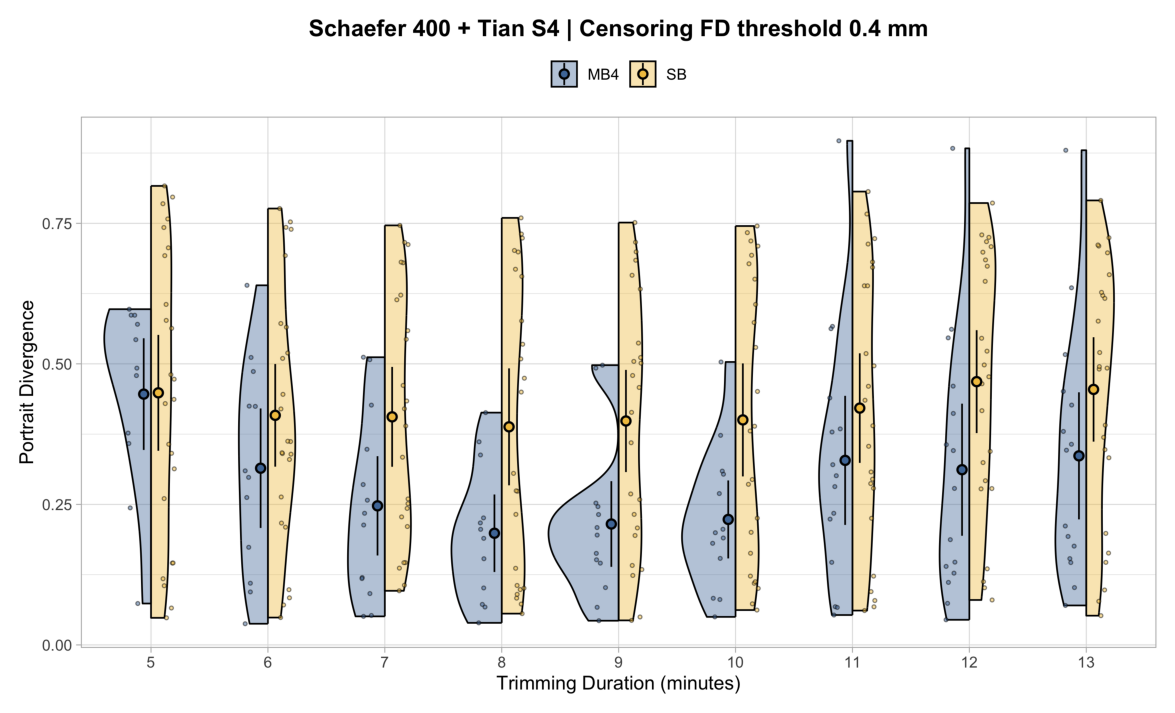

In [18]:
fig, ax = create_split_violin_plot(df, atlas_variant, roi, fd_thr)
plt.show()
